In [1]:
import  sys
sys.path = ['/data/xianliang/project_ctaintern/']+sys.path

import pandas as pd
import matplotlib.pyplot as plt
import pyelf.elutil as eu
import numpy as np
import datetime
import os
import pyelf.commodity_list as commlist

import Tools.MLTools as mltool
import itertools

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

print(plt.style.available)
plt.style.use('seaborn')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:

def ResampleDayCumFunc(df, cperiod, rule='sum', dayed_time=datetime.time(15,0)):
    idf = df.copy()
    cols_ = idf.columns.tolist()
    idf['index'] = idf.index
    idf['indexC'] = [ix+datetime.timedelta(minutes=cperiod) for ix in idf.index]

    shift = 0
    idf['day_clabel'] = 1*(idf['indexC'].apply(lambda x: x.time()) == dayed_time)
    idf['day_olabel'] = idf['day_clabel'].shift(1+shift)
    idf.loc[idf.index[0+shift], 'day_olabel'] = 1

    idf['kn'] = range(len(idf))
    idf['kn_open'] = np.nan
    idf.loc[idf['day_olabel']==1, 'kn_open'] = idf.loc[idf['day_olabel']==1, 'kn']
    idf['kn_open'] = idf['kn_open'].fillna(method='ffill')

    idf['kn'] = idf['kn']-idf['kn_open']

    idf['day_clabel'] = idf['day_clabel'].cumsum()
    idf['day_olabel'] = idf['day_olabel'].cumsum()
    idf['day_olabel'] = idf['day_olabel'].fillna(method='bfill')

    if rule=='sum':
        idf_out = idf[cols_].groupby(idf['day_olabel']).cumsum()
    elif rule=='max':
        idf_out = idf[cols_].groupby(idf['day_olabel']).cummax()
    elif rule=='min':
        idf_out = idf[cols_].groupby(idf['day_olabel']).cummin()
    elif rule=='count':
        idf_out = idf[cols_].groupby(idf['day_olabel']).cumcount()
    elif rule=='mean':
        idf_out = idf[cols_].groupby(idf['day_olabel']).cumsum().div(idf[cols_].groupby(idf['day_olabel']).cumcount(), axis=0)
    
    return idf_out

In [3]:
outdir = '/data/xianliang/CTA/Exp-Demo/'
mltool.myMakeDir(outdir)
figpath = os.path.join(outdir, 'FactorExploration')

In [140]:
datadir = '/data/xianliang/project_ctaintern/data2016_left/zl/'
period = 5
cperiod = 5
dayed_time = datetime.time(15,0)


comms = commlist.comms_all


date_b = datetime.datetime(2016,1,1)

data_zl = mltool.CTA_LoadData_AutoFactor(datadir,period,aux_cols=['if_jy','amount','twap','vwap'],date_b=date_b,cols=comms,ref_ind=None,if_parquet=True)

O = data_zl['O'].copy()
C = data_zl['C'].copy()
H = data_zl['H'].copy()
L = data_zl['L'].copy()
V = data_zl['V'].copy()
I = data_zl['I'].copy()
amount = data_zl['amount'].copy()
if_jy = data_zl['if_jy'].copy()


In [141]:
cperiod = 5
dayed_time = datetime.time(15,0)


idf = C.copy()
cols_ = idf.columns.tolist()
idf['index'] = idf.index
idf['indexC'] = [ix+datetime.timedelta(minutes=cperiod) for ix in idf.index]

idf['day_clabel'] = 1*(idf['indexC'].apply(lambda x: x.time()) == dayed_time)

idf['day_olabel'] = idf['day_clabel'].shift(1)
idf.loc[idf.index[0], 'day_olabel'] = 1
day_group_label = idf['day_olabel'].cumsum().fillna(method='bfill')

idf['day_firstbar'] = idf['day_olabel'].shift(1)


# today dayclose
day_CC = C.copy()
day_CC.loc[idf['day_clabel']!=1, :] = np.nan
day_CC = day_CC.fillna(method='bfill')

# today dayopen
day_OO = O.copy()
day_OO.loc[idf['day_clabel'].shift(1)!=1, :] = np.nan
day_OO.loc[O.index[0], :] = O.loc[O.index[0], :]
day_OO = day_OO.fillna(method='ffill')

# yesterday dayclose
day_CC1 = C.copy()
day_CC1.loc[idf['day_clabel']!=1, :] = np.nan
day_CC1 = day_CC1.fillna(method='ffill')
day_CC1 = day_CC1.shift(1)

# yesterday dayopen
day_OO1 = O[idf['day_olabel']==1]
day_OO1 = day_OO1.shift(1)
day_OO1 = day_OO1.reindex(C.index)
day_OO1 = day_OO1.fillna(method='ffill')

# nxtday open
nday_OO1 = O[idf['day_olabel']==1]
day_open_index = nday_OO1.index
nday_OO1 = nday_OO1.shift(-1)
nday_OO1 = nday_OO1.reindex(C.index)
nday_OO1 = nday_OO1.fillna(method='ffill')

# nxtday firstbar close
nday_1stC = C[idf['day_olabel']==1]
nday_1stC.index = day_open_index
nday_1stC = nday_1stC.shift(-1)
nday_1stC = nday_1stC.reindex(C.index)
nday_1stC = nday_1stC.fillna(method='ffill')

day_CC.tail()

,a,ap,b,c,cf,cy,cs,jd,lh,m,...,v,ag,al,au,cu,ni,pb,sn,zn,si
index,,,,,,,,,,,,,,,,,,,,,
2023-02-15 14:35:00,4844.882827,8875.917301,29599.316501,2850.902199,12975.748345,19263.751636,2733.299916,1922.164677,10304.113523,9896.587464,...,6205.066229,3404.066195,16423.750152,337.458632,74401.219758,235045.191844,18719.723049,228019.996853,27958.391338,17885.0
2023-02-15 14:40:00,4844.882827,8875.917301,29599.316501,2850.902199,12975.748345,19263.751636,2733.299916,1922.164677,10304.113523,9896.587464,...,6205.066229,3404.066195,16423.750152,337.458632,74401.219758,235045.191844,18719.723049,228019.996853,27958.391338,17885.0
2023-02-15 14:45:00,4844.882827,8875.917301,29599.316501,2850.902199,12975.748345,19263.751636,2733.299916,1922.164677,10304.113523,9896.587464,...,6205.066229,3404.066195,16423.750152,337.458632,74401.219758,235045.191844,18719.723049,228019.996853,27958.391338,17885.0
2023-02-15 14:50:00,4844.882827,8875.917301,29599.316501,2850.902199,12975.748345,19263.751636,2733.299916,1922.164677,10304.113523,9896.587464,...,6205.066229,3404.066195,16423.750152,337.458632,74401.219758,235045.191844,18719.723049,228019.996853,27958.391338,17885.0
2023-02-15 14:55:00,4844.882827,8875.917301,29599.316501,2850.902199,12975.748345,19263.751636,2733.299916,1922.164677,10304.113523,9896.587464,...,6205.066229,3404.066195,16423.750152,337.458632,74401.219758,235045.191844,18719.723049,228019.996853,27958.391338,17885.0


In [142]:

def SignSR(data, xp):
    cdf = data['C']
    ret1 = cdf.pct_change()
    srdf = ret1.rolling(window=xp,min_periods=1).mean()/ret1.rolling(window=xp,min_periods=1).std()
    nameflag_ = 'SignSR%d'%xp
    return srdf, nameflag_


In [156]:
yp = 1

ydf = 100.0*(day_CC/C-1)


xp = 64
factorname = 'SignSR'

factordf, name_ = eval(factorname)(data_zl, xp)
factordf.tail()

,a,ap,b,c,cf,cy,cs,jd,lh,m,...,v,ag,al,au,cu,ni,pb,sn,zn,si
index,,,,,,,,,,,,,,,,,,,,,
2023-02-15 14:35:00,0.067784,-0.047849,-0.200253,-0.108133,-0.163097,-0.221447,-0.130954,0.178284,0.101991,-0.177234,...,0.063768,-0.083689,-0.246420,-0.104993,-0.091336,-0.198277,-0.046016,-0.171725,-0.319827,-0.037373
2023-02-15 14:40:00,0.072253,-0.038022,-0.174181,-0.079495,-0.148962,-0.174088,-0.130906,0.178284,0.120914,-0.160390,...,0.103004,-0.061205,-0.224657,-0.092439,-0.059838,-0.161349,0.000160,-0.147739,-0.282152,-0.067624
2023-02-15 14:45:00,0.077646,-0.047553,-0.154259,-0.062957,-0.084051,-0.149778,-0.110608,0.175727,0.104965,-0.126994,...,0.107040,-0.037822,-0.211708,-0.075810,-0.021909,-0.143345,-0.015464,-0.128900,-0.252596,-0.072829
2023-02-15 14:50:00,0.093498,-0.032857,-0.162531,-0.079465,-0.072715,-0.109617,-0.119663,0.178216,0.078428,-0.150844,...,0.110886,-0.032003,-0.185263,-0.058548,-0.026407,-0.114932,0.030703,-0.100577,-0.215218,-0.034587
2023-02-15 14:55:00,0.050559,-0.036035,-0.159597,-0.079490,-0.072632,-0.092805,-0.082438,0.150270,0.092490,-0.164603,...,0.077063,-0.026156,-0.199296,-0.025097,-0.035343,-0.126178,-0.027231,-0.112959,-0.254789,-0.058512


In [15]:
import glob
def making_coldic(filepath):
    filepath = filepath + '*'
    pathlist = glob.glob(filepath)
    pathlist.sort()
    cols = ['C', 'V', 'BP', 'BV', 'AP', 'AV', 'OPI', 'amount', 'ifjy']
    cols.sort()
    col_dic = {}
    for i in range(0, len(cols)):
        print('loading...', cols[i])
        col_dic[cols[i]] = pd.read_parquet(pathlist[i], engine='pyarrow')
    return col_dic

col_dic = making_coldic(filepath='/data/mingkun/CTA/(New_lower)1tick_resample=0_outcomes/begdate=20200101/')

loading... AP
loading... AV
loading... BP
loading... BV
loading... C
loading... OPI
loading... V
loading... amount
loading... ifjy


In [98]:
data_zltick = {}
data_zltick['C'] = col_dic['C']
data_zltick['V'] = col_dic['V']
data_zltick['bidv'] = col_dic['BV'].fillna(0)
data_zltick['askv'] = col_dic['AV'].fillna(0)
data_zltick['bidp'] = col_dic['BP'].replace([0], np.nan).fillna(method='ffill')
data_zltick['askp'] = col_dic['AP'].replace([0], np.nan).fillna(method='ffill')
data_zltick['amount'] = col_dic['amount']
data_zltick['if_jy'] = col_dic['ifjy']

In [18]:
def BVAV(data, xp):
    bvadf = data['bidv']/data['askv']
    bvadf = bvadf.resample('5T').mean()
    bvadf.dropna(how='all', inplace=True)
    bvadf = bvadf.rolling(window=xp).mean()
    nameflag_ = 'BVAV%d'%xp
    return bvadf, nameflag_

In [20]:
xp = 1
factorname = 'BVAV'

factordf, name_ = eval(factorname)(data_zltick, xp)
factordf.tail()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2022-06-30 14:40:00,3.470100,2.276452,3.375357,9.495212,4.476304,1.927849,4.364315,1.592713,2.382221,4.687075,...,2.285554,1.526956,2.144372,0.888546,4.058432,4.232464,3.917115,4.321597,2.878768,2.076517
2022-06-30 14:45:00,5.985891,3.331261,2.714723,4.980232,2.985682,3.092880,3.914456,1.207846,1.551674,4.727333,...,4.285822,1.813598,2.625059,1.901250,2.408222,4.019036,7.026533,4.050053,3.334195,3.144793
2022-06-30 14:50:00,4.418414,3.038296,2.515823,3.218220,2.271298,1.653771,8.550914,1.176361,3.139750,1.674312,...,2.893660,2.143120,2.363182,2.666551,2.499236,4.334077,4.512197,6.320331,3.490720,4.156263
2022-06-30 14:55:00,4.820767,3.835823,1.992641,5.429852,2.065890,1.393828,4.797652,2.207541,2.206183,1.939922,...,3.449322,1.854605,3.597950,1.710646,3.857421,8.609558,3.369851,3.405186,2.932673,2.409770
2022-06-30 15:00:00,NaN,0.030303,0.571429,NaN,NaN,0.750000,0.285714,NaN,NaN,NaN,...,NaN,3.000000,0.083333,NaN,0.315789,NaN,NaN,0.600000,1.558140,28.000000


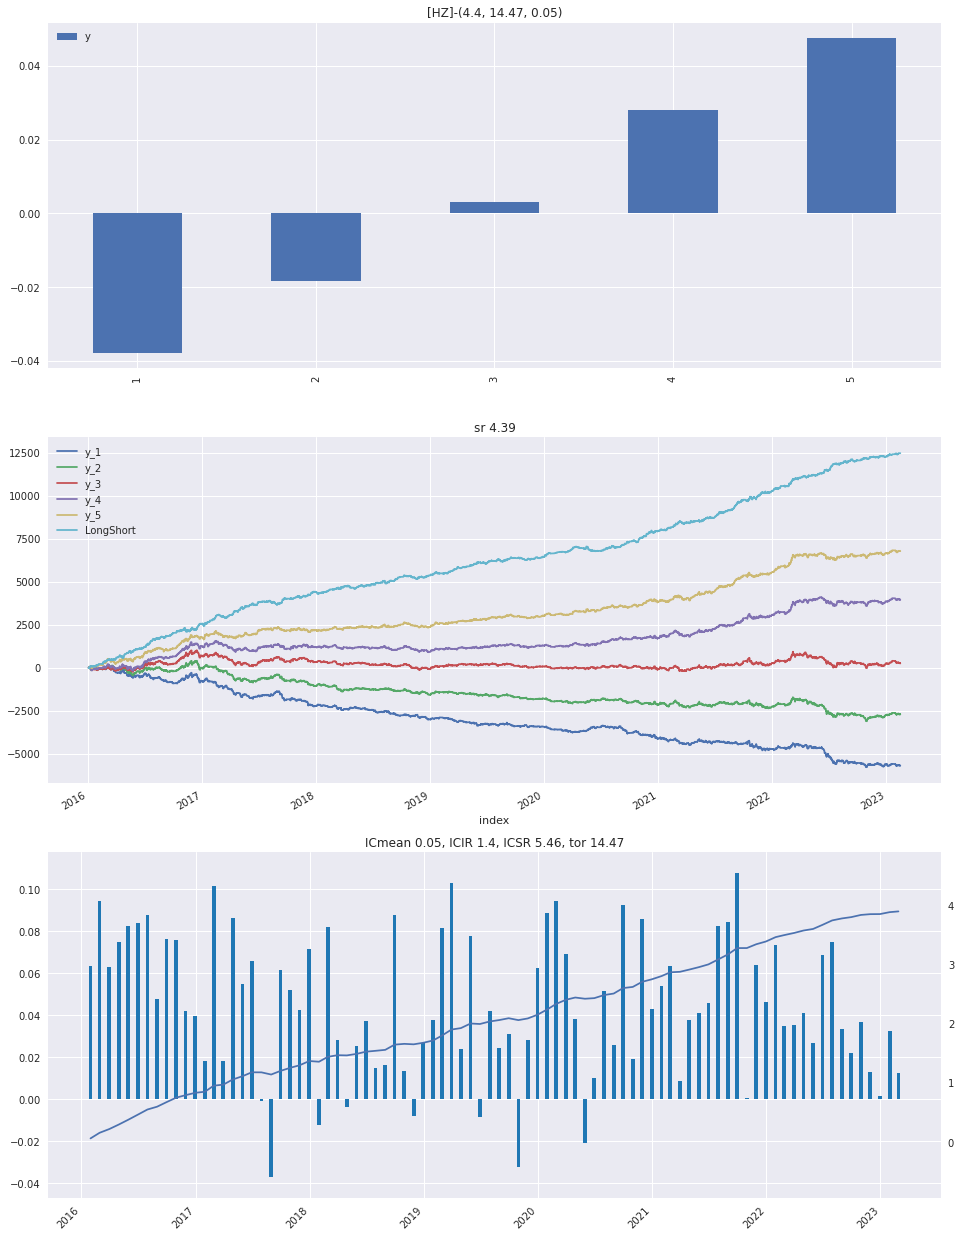

In [162]:
cuts = 5
'''
if_jy 保存该品种是否交易标签, 不交易的品种因子值设置成nan
横截面多空因子分析
'''
factordf[if_jy==0] = np.nan

name_, icvalue, deltanp, sr, factor_group = mltool.FactorPerform(factordf, ydf, plt_ycol='', bin_ycols=[], cuts=cuts, ifqcut=True, if_savefig=True, figpath=figpath, nameflag_='[HZ]', if_show_ls=True)


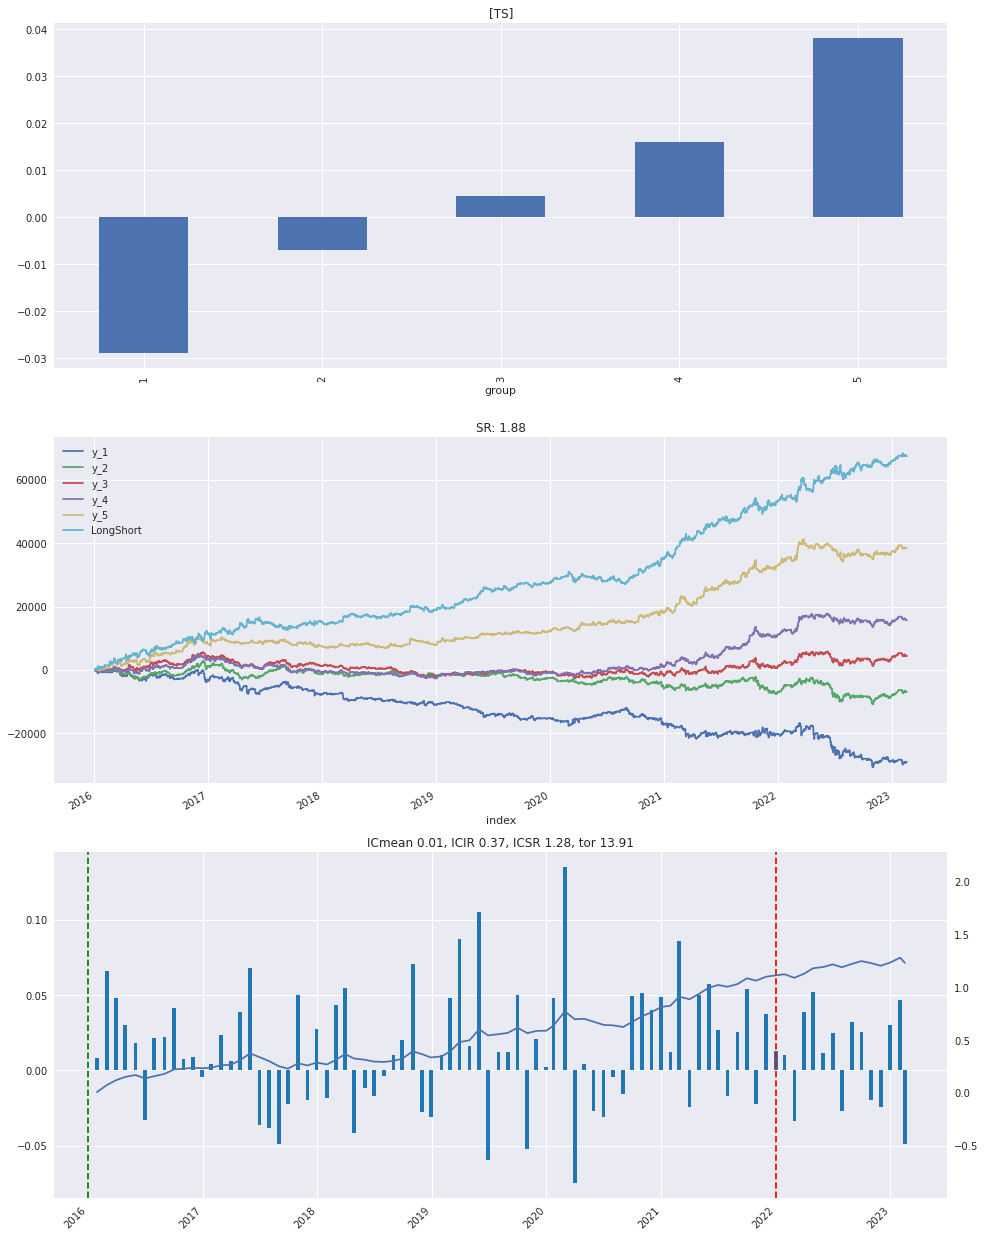

In [9]:
'''
时间序列因子分析, 只有一个ydf
'''

cuts = 50
ifqcut = True
startdate = datetime.datetime(2016,1,1)
enddate = datetime.datetime(2022,1,1)


cuts = 5


a,b,npsdf_ts_sig,nfactordf_ts_sig = mltool.FactorPerform_TS(factordf, ydf, if_jy, cuts, ifqcut, startdate, enddate, nameflag_='[TS]', scomms=[], plt_groups=[], if_plot_all=False, if_plot_ls=True, if_savefig=False, figpath=figpath)

In [158]:
ydf_dict = {}
ydf_dict['y_hd1'] = 100.0*(C.shift(-1)/C-1)
ydf_dict['y_hd6'] = 100.0*(C.shift(-6)/C-1)
ydf_dict['y_dayC'] = 100.0*(day_CC/C-1)
ydf_dict['y_ndayO'] = 100.0*(nday_OO1/C-1)
ydf_dict['y_nday1stC'] = 100.0*(nday_1stC/C-1)

In [58]:
xp = 1
HH = data_zltick['askp'].resample('5T').max()
LL = data_zltick['bidp'].resample('5T').min()
VV = (data_zltick['C']*data_zltick['V']).resample('5T').sum()/data_zltick['V'].resample('5T').sum()
bvadf = HH*LL/(VV*VV)
bvadf.dropna(how='all', inplace=True)
bvadf = bvadf.rolling(window=xp).mean()
bvadf.tail()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2022-06-30 14:40:00,1.022253,0.998942,0.999275,0.996886,0.998923,0.989516,1.004422,0.998383,0.670040,1.001336,...,0.999518,1.009221,1.002957,1.000650,0.927623,0.995584,0.565212,0.997064,0.999738,1.015016
2022-06-30 14:45:00,1.022227,0.998908,0.999306,0.997001,0.998949,0.989261,1.003993,0.998478,0.669260,1.000019,...,0.999070,1.009571,1.004127,1.000860,0.928273,0.995909,0.566502,0.997815,0.999634,1.015198
2022-06-30 14:50:00,1.022137,0.999160,0.999344,0.997981,0.998811,0.989230,1.005331,0.998315,0.670206,0.998505,...,0.999043,1.010359,1.003605,1.001067,0.928758,0.996929,0.565755,0.997798,0.999789,1.015484
2022-06-30 14:55:00,1.021999,0.998945,0.999184,0.997403,0.998872,0.989592,1.004419,0.998264,0.669319,0.999154,...,0.998879,1.009879,1.003823,1.001206,0.927954,0.995739,0.564906,0.996854,0.999703,1.014520
2022-06-30 15:00:00,NaN,0.998713,0.999446,NaN,NaN,NaN,1.004025,NaN,NaN,NaN,...,NaN,1.009217,1.003417,NaN,0.927879,NaN,NaN,NaN,NaN,1.015125


In [179]:
xp = 1

ask_vwap = (data_zltick['askp']*data_zltick['askv']).fillna(0).resample('5T').sum()/data_zltick['askv'].fillna(0).resample('5T').sum()
bid_vwap = (data_zltick['bidp']*data_zltick['bidv']).fillna(0).resample('5T').sum()/data_zltick['bidv'].fillna(0).resample('5T').sum()
midprice = (data_zltick['bidp']+data_zltick['askp'])/2

avg_vwap = (midprice*data_zltick['V']).fillna(0).resample('5T').sum()/data_zltick['V'].fillna(0).resample('5T').sum()

bvadf = avg_vwap.copy()
bvadf.dropna(how='all', inplace=True)
bvadf = bvadf.rolling(window=xp).mean()
bvadf.tail()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2022-06-30 14:40:00,7012.119350,4250.184815,21202.751351,5471.769237,384.014734,5646.233482,3347.485268,2749.959884,13860.176650,5879.969661,...,7460.694211,243986.189056,7544.915192,5516.067308,21536.315868,5849.899483,2533.875898,8262.248214,13398.225100,25631.918749
2022-06-30 14:45:00,7008.232717,4252.570940,21171.180206,5471.680152,384.114065,5643.582142,3344.970084,2749.746543,13865.683386,5877.783033,...,7465.478874,243426.572895,7541.472522,5512.695365,21496.931249,5853.046276,2531.075954,8254.309117,13397.451653,25618.573621
2022-06-30 14:50:00,7011.995101,4247.282974,21148.715761,5462.582603,384.096300,5638.488812,3338.067475,2751.933115,13860.797906,5882.432802,...,7470.261009,242445.402384,7533.799521,5510.184667,21440.965985,5838.505610,2531.503784,8230.846243,13382.189151,25567.500096
2022-06-30 14:55:00,7020.505130,4243.515250,21153.819594,5464.385587,384.069207,5633.642602,3340.648987,2749.426983,13864.855206,5897.612112,...,7465.077425,242002.718579,7529.463595,5510.613385,21417.910072,5841.917315,2535.221765,8242.110778,13389.245235,25541.878319
2022-06-30 15:00:00,NaN,4245.965676,21150.808159,NaN,NaN,NaN,3343.527546,NaN,NaN,NaN,...,NaN,241792.907513,7533.378985,NaN,21425.310350,NaN,NaN,NaN,NaN,25499.082517


In [185]:
ask_vwap.tail()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2022-06-30 14:40:00,6947.861939,4248.751108,21045.413895,5473.863763,383.674649,5545.176765,3344.533817,2747.560861,16625.400133,5872.125022,...,7455.783678,240166.244981,7525.848348,5515.919533,20627.698311,5849.572552,3239.108987,8255.155024,13380.104251,25356.033777
2022-06-30 14:45:00,6945.002805,4250.612011,21010.222037,5471.996906,383.780887,5543.454704,3342.214952,2747.428215,16635.381712,5869.781633,...,7460.897479,239679.657666,7522.796117,5513.522182,20601.920487,5853.017641,3233.896060,8244.456315,13380.775299,25345.568000
2022-06-30 14:50:00,6947.819385,4246.898014,20991.148990,5464.618568,383.755799,5537.416154,3334.835087,2749.540663,16628.051506,5872.766418,...,7461.705797,238707.080898,7515.671851,5510.126164,20536.481106,5840.049739,3233.683956,8221.074932,13364.925697,25299.502016
2022-06-30 14:55:00,6956.714042,4241.941430,20992.961086,5467.829779,383.724908,5533.339936,3336.992395,2747.372807,16639.620031,5890.168459,...,7460.872453,238232.036851,7510.997323,5509.949765,20519.763767,5840.826901,3242.226125,8232.532066,13372.947591,25274.035425
2022-06-30 15:00:00,NaN,4244.296342,20989.119559,NaN,NaN,5538.639639,3340.162142,NaN,NaN,NaN,...,NaN,238026.398647,7514.521927,NaN,20521.623960,NaN,NaN,8241.156048,13371.566335,25223.913634


In [186]:
avg_vwap = (ask_vwap+bid_vwap)/2
bvadf = avg_vwap.copy()
bvadf.dropna(how='all', inplace=True)
bvadf = bvadf.rolling(window=1).mean()
bvadf.tail()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2022-06-30 14:40:00,7012.177406,4250.319498,21204.591458,5470.979162,384.012143,5646.083042,3347.491754,2749.734964,13860.200066,5880.768365,...,7461.192809,243966.712127,7544.510841,5516.176589,21535.229803,5849.541922,2534.410190,8264.101502,13397.174001,25631.836586
2022-06-30 14:45:00,7008.710056,4252.361964,21171.110134,5471.478515,384.118932,5644.197774,3345.193932,2749.577699,13865.190856,5878.892767,...,7466.348091,243456.061125,7540.976527,5513.921720,21504.430847,5852.838115,2531.803726,8253.478906,13397.676882,25618.533991
2022-06-30 14:50:00,7012.065132,4248.450902,21150.933892,5462.692580,384.095073,5638.421287,3338.231859,2751.837338,13861.525753,5880.683236,...,7469.318670,242483.683769,7534.109974,5510.299403,21440.559602,5840.785598,2531.697674,8230.445219,13382.062572,25576.043695
2022-06-30 14:55:00,7020.819761,4243.393792,21154.574726,5465.659087,384.066055,5634.323217,3340.289722,2749.535738,13867.310015,5896.217878,...,7465.594981,242008.791606,7529.366341,5510.156604,21418.354262,5841.230291,2535.968759,8241.302278,13390.184529,25546.626469
2022-06-30 15:00:00,NaN,4245.965676,21150.808159,NaN,NaN,5639.251686,3343.527546,NaN,NaN,NaN,...,NaN,241792.907513,7533.378985,NaN,21425.310350,NaN,NaN,8250.515190,13387.946697,25499.082517


In [167]:
xp = 5*64*120
# HH = data_zltick['askp'].rolling(window=xp).max()
# LL = data_zltick['bidp'].rolling(window=xp).min()
# VV = (data_zltick['C']*data_zltick['V'].fillna(0)).rolling(window=xp).sum()/data_zltick['V'].fillna(0).rolling(window=xp).sum()
# bvadf = HH*LL/(VV*VV)
# RR = data_zltick['C'].pct_change().fillna(0)
# bvadf = RR.rolling(window=xp).mean()/RR.rolling(window=xp).std()
# bid_ps = 1*(data_zltick['bidp']>data_zltick['bidp'].shift(1))-1*(data_zltick['bidp']<data_zltick['bidp'].shift(1))
# ask_ps = 1*(data_zltick['askp']>data_zltick['askp'].shift(1))-1*(data_zltick['askp']<data_zltick['askp'].shift(1))
# signv = bid_ps*data_zltick['bidv']+ask_ps*data_zltick['askv']
bid_signv = 1*(data_zltick['bidp']>data_zltick['bidp'].shift(1))*data_zltick['bidv']-1*(data_zltick['bidp']<data_zltick['bidp'].shift(1))*data_zltick['bidv'].shift(1)
ask_signv = 1*(data_zltick['askp']>data_zltick['askp'].shift(1))*data_zltick['askv'].shift(1)-1*(data_zltick['askp']<data_zltick['askp'].shift(1))*data_zltick['askv']
signv = bid_signv+ask_signv
bvadf = signv.rolling(xp).sum()/(data_zltick['bidv']+data_zltick['askv']).rolling(window=xp).sum()
bvadf = bvadf.resample('5T').last()
bvadf.dropna(how='all', inplace=True)
bvadf = bvadf.rolling(window=1).mean()
bvadf.tail()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2022-06-30 14:40:00,-0.000034,0.000446,-0.000278,-0.003149,-0.004837,0.003471,0.002502,-0.000446,-0.042780,-0.006628,...,-0.004627,-0.002305,0.001622,-0.000531,0.003469,0.000369,-0.019739,-0.000618,-0.000369,-0.000614
2022-06-30 14:45:00,0.000025,0.000445,-0.000346,-0.001558,-0.004425,0.003931,0.002437,-0.000297,-0.042601,-0.007043,...,-0.004603,-0.003607,0.001588,-0.000594,0.003211,0.000233,-0.020186,-0.001008,0.000056,-0.000787
2022-06-30 14:50:00,0.000395,0.000113,-0.000452,-0.001803,-0.004081,0.004017,0.001163,-0.000181,-0.042711,-0.006401,...,-0.003971,-0.006143,0.001514,-0.000517,0.003146,-0.000322,-0.020058,-0.002393,0.000234,-0.001063
2022-06-30 14:55:00,0.000520,-0.000019,-0.000323,-0.002391,-0.004190,0.004355,0.001662,-0.000239,-0.042159,-0.003780,...,-0.004207,-0.005377,0.001409,-0.000796,0.003109,-0.000264,-0.019857,-0.001822,-0.000189,-0.001424
2022-06-30 15:00:00,0.000520,-0.000019,-0.000323,-0.002391,-0.004194,0.004355,0.001647,-0.000239,-0.042161,-0.003780,...,-0.004207,-0.005469,0.001409,-0.000796,0.003108,-0.000264,-0.019857,-0.001822,-0.000180,-0.001424


In [123]:
# bvadf = signv.rolling(xp).sum()/(data_zltick['bidv']+data_zltick['askv']+data_zltick['bidv'].shift(1)+data_zltick['askv'].shift(1)).rolling(window=xp).sum()
xp = 5*64*120
bvadf = signv.rolling(xp).sum()/(data_zltick['V'].fillna(0)).rolling(window=xp).sum()
bvadf = bvadf.resample('5T').last()
bvadf.dropna(how='all', inplace=True)
bvadf = bvadf.rolling(window=1).mean()
bvadf.tail()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2022-06-30 14:40:00,-0.000788,0.009280,-0.004848,-0.007591,-0.038976,0.026786,0.016743,-0.036659,-0.136015,-0.038658,...,-0.021776,-0.005465,0.025754,-0.010677,0.056202,0.001771,-0.144185,-0.002158,-0.002348,-0.006561
2022-06-30 14:45:00,0.000568,0.009380,-0.006025,-0.003804,-0.036552,0.030958,0.016453,-0.024597,-0.135666,-0.041079,...,-0.022273,-0.008989,0.025310,-0.011843,0.051708,0.001122,-0.147187,-0.003518,0.000363,-0.008431
2022-06-30 14:50:00,0.008999,0.002382,-0.007887,-0.004415,-0.034078,0.031772,0.007910,-0.015141,-0.136213,-0.037764,...,-0.019644,-0.015658,0.024180,-0.010247,0.050418,-0.001533,-0.146844,-0.008515,0.001507,-0.011274
2022-06-30 14:55:00,0.011582,-0.000394,-0.005579,-0.005801,-0.035010,0.034038,0.011406,-0.019362,-0.135627,-0.022316,...,-0.020855,-0.013991,0.022517,-0.015540,0.049441,-0.001241,-0.145148,-0.006428,-0.001216,-0.015115
2022-06-30 15:00:00,0.011582,-0.000394,-0.005579,-0.005801,-0.035044,0.034039,0.011306,-0.019363,-0.135632,-0.022316,...,-0.020855,-0.014231,0.022529,-0.015541,0.049440,-0.001241,-0.145148,-0.006428,-0.001158,-0.015114


In [122]:
xp

1

In [175]:
xp = 5*64*120
midprice = (data_zltick['bidp']+data_zltick['askp'])/2
ps = 1*(midprice>midprice.shift(1))-1*(midprice<midprice.shift(-1))
signv = ps*data_zltick['V'].fillna(0)
bvadf = signv.rolling(xp).sum()/(data_zltick['V'].fillna(0)).rolling(window=xp).sum()
bvadf = bvadf.resample('5T').last()
bvadf.dropna(how='all', inplace=True)
bvadf = bvadf.rolling(window=1).mean()
bvadf.tail()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2022-06-30 14:40:00,0.175658,0.052116,0.049299,0.374511,0.075560,0.137411,0.034140,0.109009,0.306057,0.334613,...,0.344270,0.005681,0.018190,0.244257,0.039653,0.298404,0.285667,0.044391,0.080606,0.042466
2022-06-30 14:45:00,0.172943,0.053102,0.047888,0.374144,0.075224,0.136631,0.035656,0.110765,0.306642,0.332157,...,0.341941,0.007342,0.016700,0.243010,0.038530,0.298563,0.281064,0.043330,0.080569,0.041559
2022-06-30 14:50:00,0.176376,0.050198,0.047130,0.373375,0.073623,0.134945,0.036413,0.113836,0.306763,0.333913,...,0.341763,0.007679,0.015739,0.242011,0.037451,0.296583,0.280104,0.043242,0.081606,0.040534
2022-06-30 14:55:00,0.175818,0.048725,0.046946,0.371386,0.076755,0.127397,0.036975,0.113632,0.304090,0.334508,...,0.339162,0.008490,0.017135,0.241652,0.035343,0.295143,0.278721,0.043591,0.081275,0.038075
2022-06-30 15:00:00,0.175818,0.048725,0.046946,0.371386,0.076755,0.127402,0.036834,0.113633,0.304101,0.334508,...,0.339162,0.008319,0.017144,0.241666,0.035342,0.295147,0.278721,0.043594,0.081275,0.038074


In [90]:
bvadf.head()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 22:30:00,0.997624,0.989175,0.995940,0.999223,1.000490,0.999925,0.995217,1.000163,1.001052,0.999783,...,1.000936,1.001252,0.999908,1.003829,1.004646,1.003019,1.001010,1.000638,1.000082,0.999543
2020-01-02 22:35:00,0.998379,0.999874,0.996036,0.998914,1.001072,1.003593,0.999986,1.000886,1.000961,0.999693,...,1.001111,1.002691,0.999788,1.003847,1.005154,1.000244,1.001282,1.000176,1.002516,0.999806
2020-01-02 22:40:00,0.999128,0.999353,0.996125,0.999704,1.001652,1.003539,0.999701,1.000800,1.001593,0.999678,...,1.002299,1.002337,0.999727,1.003843,1.005740,0.999626,1.002269,0.999555,1.002003,0.999973
2020-01-02 22:45:00,0.999720,0.999095,0.996231,1.000746,1.001526,1.005293,0.999649,1.000697,1.002203,0.999909,...,1.001788,1.001670,0.999864,1.003243,1.005257,0.999764,1.002080,0.998963,1.001481,1.000216
2020-01-02 22:50:00,0.999638,0.998795,0.996437,1.000769,1.001807,1.005257,0.999606,1.000572,1.002732,0.999996,...,1.001208,1.000831,0.999889,0.999411,1.005977,0.999523,1.001940,0.998871,1.001059,1.000478


In [187]:
factordf0 = factordf.copy()
factordf0 = bvadf.copy()

ref_index = factordf0.index.intersection(if_jy.index)
factordf0 = factordf0.reindex(ref_index)

# factordf0[if_jy==0] = np.nan
# factordf0 = factordf0.dropna(how='all')
# factordf0 = factordf0.fillna(1)

In [188]:

xp = 64
# factordf = factordf0.rolling(window=xp).mean()
factordf = factordf0.pct_change().rolling(window=xp).mean()/factordf0.pct_change().rolling(window=xp).std()
# factordf = factordf0.rolling(window=xp).mean()/factordf0.rolling(window=xp).std()
factordf.tail()

,a,ag,al,ap,au,b,bu,c,cf,cj,...,sm,sn,sp,sr,ss,ta,ur,v,y,zn
index,,,,,,,,,,,,,,,,,,,,,
2022-06-30 14:35:00,-0.170114,-0.015785,-0.168322,-0.241795,-0.050803,-0.007961,-0.054768,-0.219564,-0.102792,-0.027932,...,-0.108673,-0.005618,-0.084536,-0.098573,0.163036,-0.048327,-0.006113,0.018981,-0.071414,-0.231941
2022-06-30 14:40:00,-0.177493,-0.004102,-0.194466,-0.227196,-0.035862,-0.024032,-0.051741,-0.225759,-0.107095,-0.033362,...,-0.102744,-0.034937,-0.065997,-0.099934,0.167653,-0.025992,-0.006119,-0.003476,-0.060730,-0.238447
2022-06-30 14:45:00,-0.177027,-0.030272,-0.227277,-0.225729,-0.061916,-0.033728,-0.056094,-0.214300,-0.108595,-0.037091,...,-0.096063,-0.108564,-0.069459,-0.109133,0.139660,-0.022777,-0.017367,-0.018385,-0.052572,-0.243596
2022-06-30 14:50:00,-0.148364,-0.026481,-0.229944,-0.246748,-0.028737,-0.022967,-0.077576,-0.167513,-0.112697,-0.033502,...,-0.092260,-0.142834,-0.070824,-0.102091,0.101796,-0.040166,-0.017827,-0.064955,-0.051641,-0.246023
2022-06-30 14:55:00,-0.100888,-0.055068,-0.227965,-0.237665,-0.049705,-0.049195,-0.083721,-0.196504,-0.114183,-0.002467,...,-0.096902,-0.160424,-0.082595,-0.080287,0.085263,-0.048415,0.000658,-0.073174,-0.059952,-0.257074


<Figure size 1152x2304 with 0 Axes>

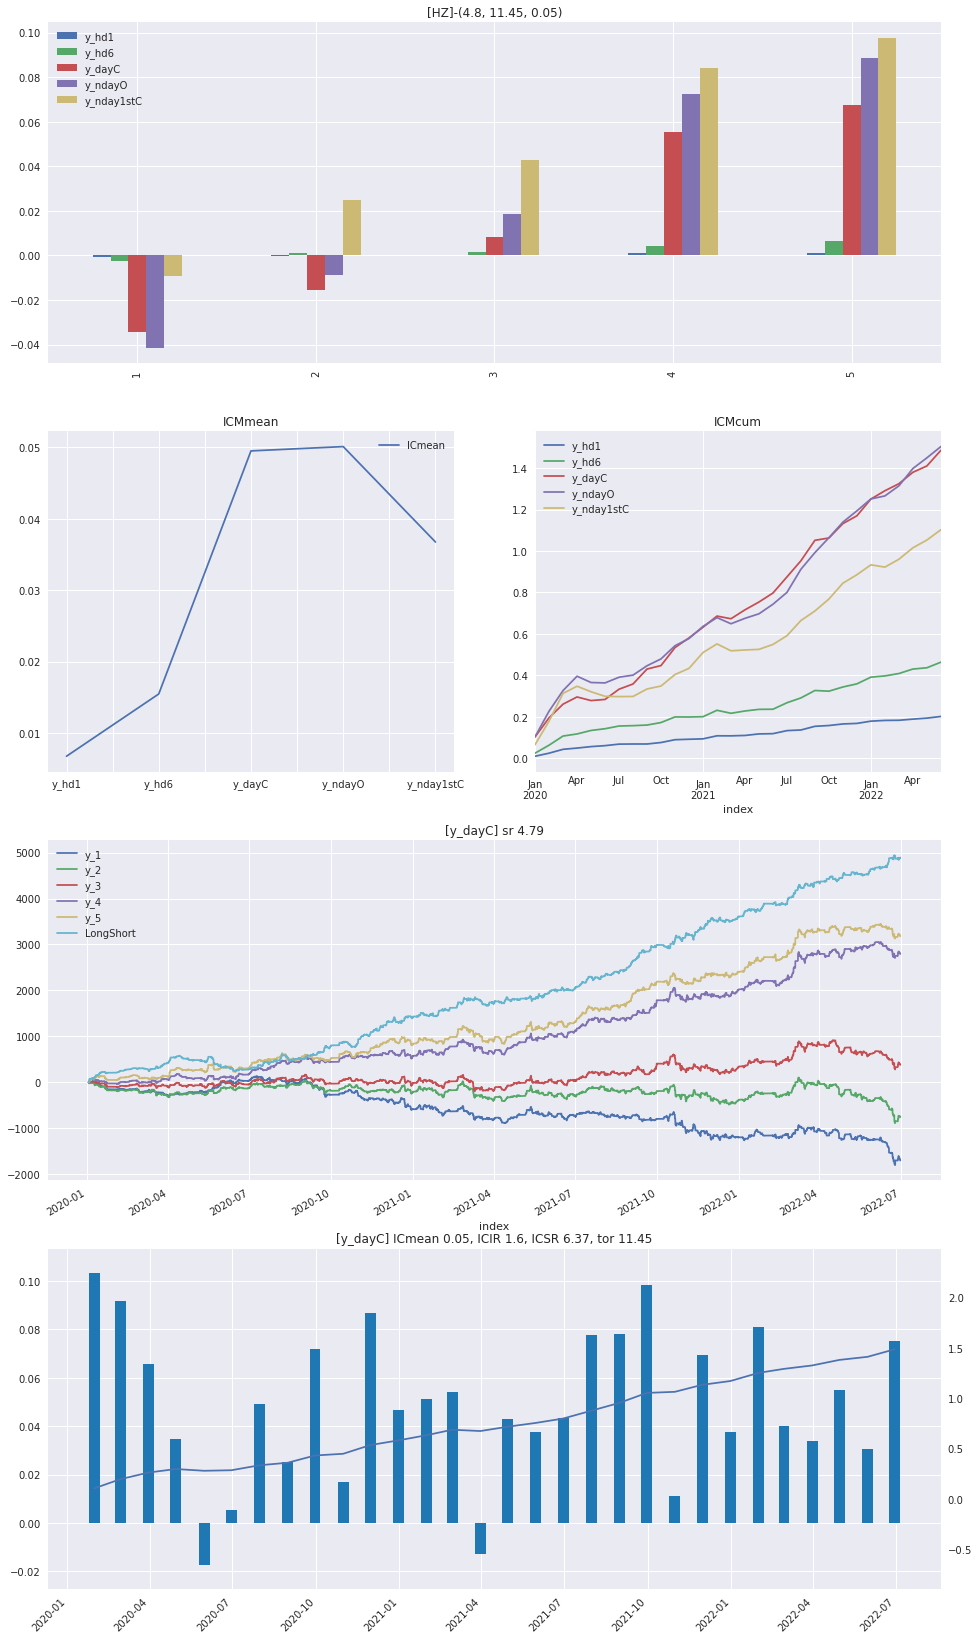

In [189]:
'''
横截面多空因子分析, 多个ydf
'''
factordf[if_jy==0] = np.nan

y_show = 'y_dayC'
# y_show = 'y_hd1'
aa, sr, icmean, icir, ic_sr, avg_tur, factor_group = mltool.FactorPerform_HZS(factordf, ydf_dict, y_show, cuts=5, if_savefig=True, figpath=figpath, nameflag_='[HZ]', if_show_ls=True)

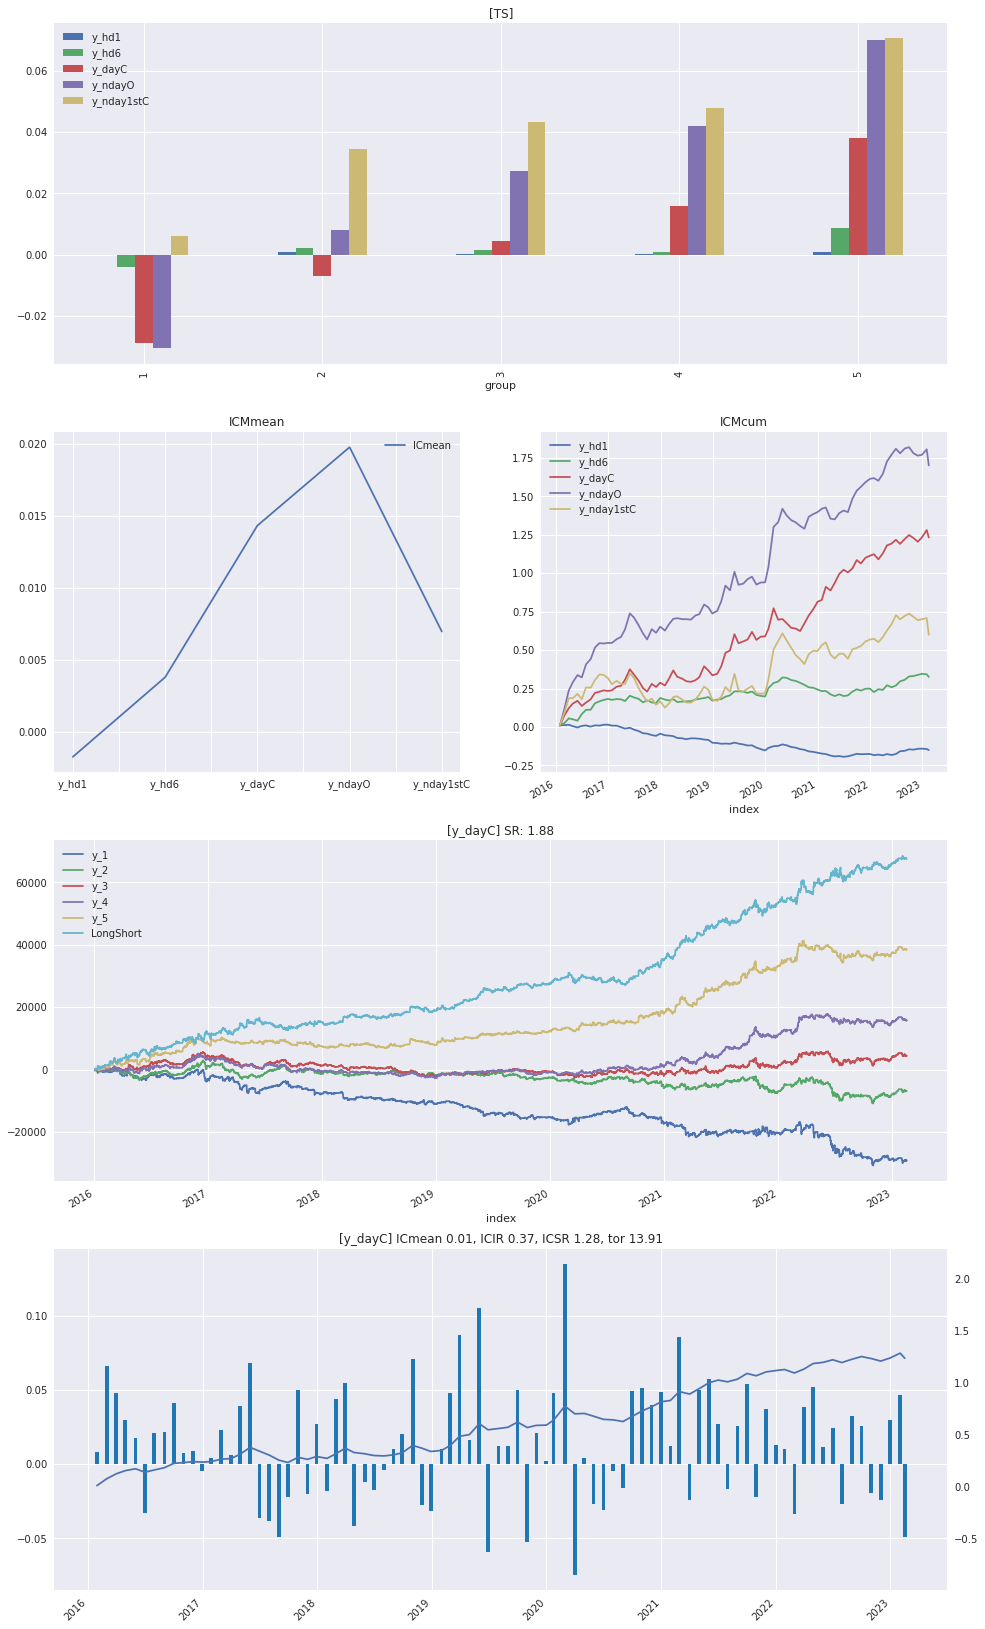

In [12]:
'''
时间序列因子分析, 多个ydf
'''
y_show = 'y_dayC'

cuts = 5
ifqcut = True
startdate = datetime.datetime(2016,1,1)
enddate = datetime.datetime(2022,1,1)


a,b,npsdf_ts_sig,nfactordf_ts_sig = mltool.FactorPerform_TSS(factordf, ydf_dict, y_show, if_jy, cuts, ifqcut, startdate, enddate, nameflag_='[TS]', scomms=[], plt_groups=[], if_plot_all=False, if_plot_ls=True, if_savefig=False, figpath=figpath)

In [13]:
'''
回测: 简单动量因子cpos, cost_penalty=0 demo 里假设手续费为0; 1表示正常手续费
'''

xp = 512

factordf = (C-C.rolling(window=xp).min())/(C.rolling(window=xp).max()-C.rolling(window=xp).min())
psdf0 = 2.0*(factordf-0.5)

data_bkt = {}
data_bkt['C'] = data_zl['C'].copy()

dfmin = mltool.GetMinProfit(psdf0, data_bkt, comms, cost_penalty=0, if_pct=True)

dfmin.tail()


,close_a,ps_a,GP_a,cost_a,NP_a,close_ap,ps_ap,GP_ap,cost_ap,NP_ap,...,close_si,ps_si,GP_si,cost_si,NP_si,TN,TradeN,GrossProfit,cost,Profit
index,,,,,,,,,,,,,,,,,,,,,
2023-02-15 14:35:00,4844.882827,0.697842,-10.645156,0.0,-10.645156,8868.859319,0.745257,69.419787,0.0,69.419787,...,17910.0,0.129412,-5.179123,0.0,-5.179123,53.0,31.831733,12.143144,0.0,12.143144
2023-02-15 14:40:00,4850.099858,0.784173,-10.570011,0.0,-10.570011,8874.909018,0.777778,69.470623,0.0,69.470623,...,17880.0,-0.011765,-5.200800,0.0,-5.200800,53.0,31.280463,12.118411,0.0,12.118411
2023-02-15 14:45:00,4849.230353,0.769784,-10.584070,0.0,-10.584070,8868.859319,0.745257,69.417605,0.0,69.417605,...,17875.0,-0.035294,-5.200471,0.0,-5.200471,53.0,30.539839,12.099081,0.0,12.099081
2023-02-15 14:50:00,4850.099858,0.784173,-10.570267,0.0,-10.570267,8877.933868,0.794038,69.493859,0.0,69.493859,...,17910.0,0.129412,-5.207381,0.0,-5.207381,53.0,30.460164,12.087692,0.0,12.087692
2023-02-15 14:55:00,4844.882827,0.697842,-10.654617,0.0,-10.654617,8875.917301,0.783198,69.475823,0.0,69.475823,...,17885.0,0.011765,-5.225446,0.0,-5.225446,53.0,31.012182,12.095952,0.0,12.095952


('sr: ', 0.3014165742304707)


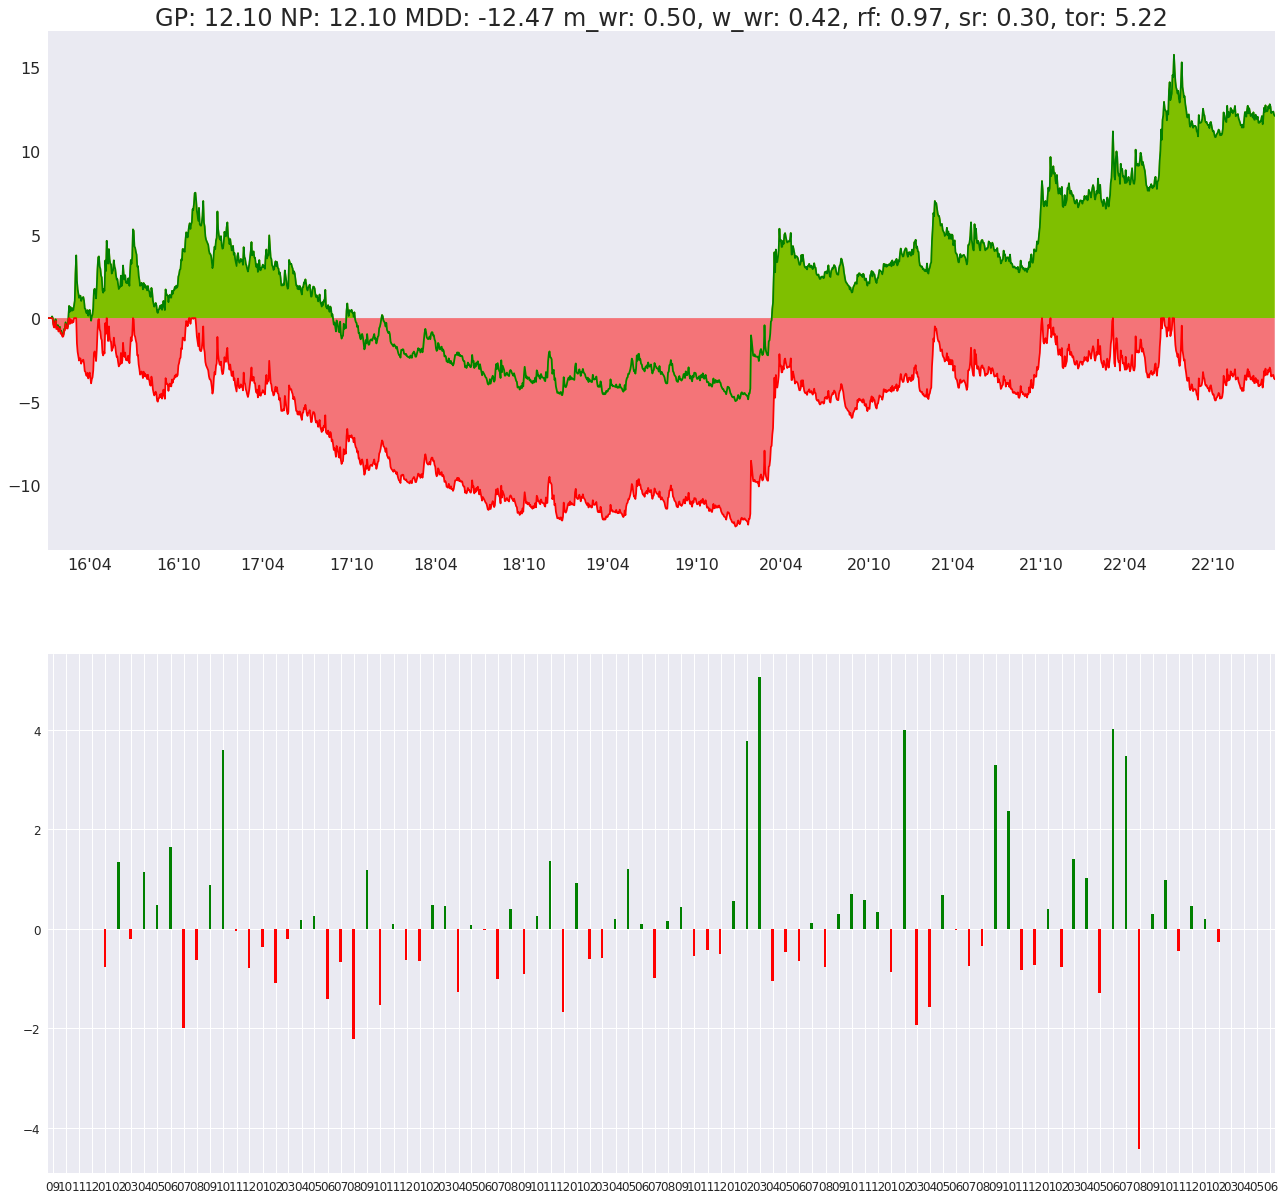

(0.3014165742304707, 5.216673470012695)

In [14]:
'''
画图
'''

mltool.PlotPerformance(dfmin, comms, figpath, nameflag_='BKT-%s'%name_, enddate=datetime.datetime(2016,1,1))